# Baseline models on resampled data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


import scikitplot as skplt

import xgboost as xgb

from utils.evaluation import evaluate_model
from utils.report import report_by_sections

In [3]:
train_data = pd.read_csv("data/train_data.csv", parse_dates=["block_time"])

In [4]:
features = [f for f in train_data.columns if f.endswith("_log_to_median_ratio")]

In [5]:
len(features)

53

In [6]:
model_train_data = train_data.loc[
    :, ["file_name", "transaction_id", "block_time"] + features + ["label"]
].fillna(0)

In [7]:
validation_data = pd.read_csv("data/validation_data.csv", parse_dates=["block_time"])

## 1 Create train sample balanced between cases

In [8]:
tx_count = train_data.groupby("file_name")["transaction_id"].nunique()

Exclude cases with very few transactions

In [9]:
tx_count[tx_count < 20]

file_name
Audius.csv                   5
CompounderFinance004.csv    14
CompounderFinance005.csv     3
Lympo002.csv                 3
Taylor001.csv                7
dxHub001.csv                18
Name: transaction_id, dtype: int64

In [10]:
files_to_exclude = list(tx_count[tx_count < 20].index)
files_to_exclude

['Audius.csv',
 'CompounderFinance004.csv',
 'CompounderFinance005.csv',
 'Lympo002.csv',
 'Taylor001.csv',
 'dxHub001.csv']

In [11]:
file_names = train_data["file_name"].drop_duplicates()

In [12]:
target_fer_file = 50
ref_per_file = 300
samples = []
np.random.seed(1234)
for f in file_names:
    if f not in files_to_exclude:
        df = train_data.loc[train_data["file_name"] == f, :]
        samples.append(
            df.loc[df["label"] == 1, :].sample(target_fer_file, replace=True)
        )
        samples.append(df.loc[df["label"] == 0, :].sample(ref_per_file, replace=True))
train_sample = pd.concat(samples).reset_index(drop=True)

In [13]:
train_sample.shape

(39200, 116)

In [14]:
train_sample["label"].value_counts()

0    33600
1     5600
Name: label, dtype: int64

## 2 Simple feature selection

In [15]:
mu_score = mutual_info_classif(
    train_sample.loc[:, features].fillna(0), train_sample["label"], random_state=1234
)

In [16]:
mu_score_df = pd.DataFrame(
    zip(features, mu_score), columns=["feature", "score"]
).sort_values("score", ascending=False)

In [17]:
# mu_score_df.to_csv("mu_score_on_resampled.csv", index=False)

In [18]:
train_sample.shape

(39200, 116)

In [19]:
selected = [
    "snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio",
    "snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio",
    "amount_usd_tx_sum_log_to_median_ratio",
    "snd_rcv_life_time_sec_tx_min_log_to_median_ratio",
    "snd_rcv_mean_time_diff_sec_tx_sum_log_to_median_ratio",
    "snd_rcv_tx_cnt_tx_sum_log_to_median_ratio",
    "snd_rcv_time_diff_sec_tx_mean_log_to_median_ratio",
]

## 3 Model training and evaluation

In [20]:
X = train_sample.loc[:, selected].fillna(0)
y = train_sample["label"]
# model = LogisticRegression(class_weight='balanced').fit(X, y)
# model = RandomForestClassifier(max_depth=4, n_estimators=100, class_weight='balanced').fit(X, y)
model = GradientBoostingClassifier(n_estimators=50, max_depth=2).fit(X, y)
# model = SVC(class_weight='balanced').fit(X, y)
# model = GaussianNB().fit(X, y)
# dtrain = xgb.DMatrix(X, y)
# param = {'max_depth': 3, 'eta': .2, 'objective': 'binary:logistic'}
# model = xgb.train(param, dtrain)
# model = DecisionTreeClassifier(max_depth=4).fit(X, y)

In [21]:
train_pred_label = model.predict(X)
# train_pred_prob = model.predict(dtrain)
# train_pred_label = (train_pred_prob > 0.5).astype(int)
train_true_label = train_sample["label"]

recall: 0.616, precision: 0.849, specificity: 0.982


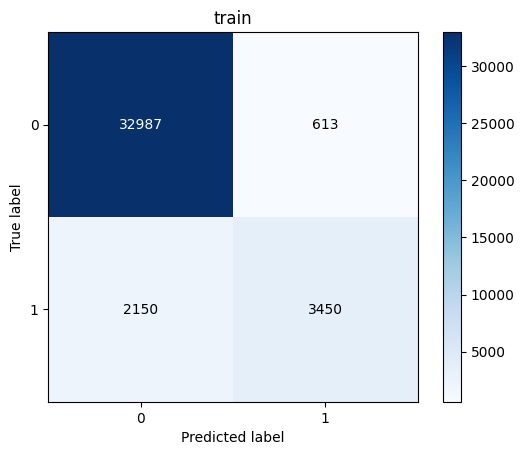

In [22]:
train_metrics = evaluate_model(
    train_true_label, train_pred_label, confusion_title="train"
)
print(
    f"recall: {train_metrics['recall']}, "
    + f"precision: {train_metrics['precision']}, "
    + f"specificity: {train_metrics['specificity']}"
)

In [23]:
validation_model_data = validation_data.loc[
    :, ["file_name", "transaction_id", "block_time"] + features + ["label"]
].fillna(0)

In [24]:
# dvalidation = xgb.DMatrix(validation_model_data.loc[:, selected], validation_model_data['label'])
# val_pred_prob = model.predict(dvalidatio)
# val_pred_label = (val_pred_prob > 0.5).astype(int)
val_pred_label = model.predict(validation_model_data.loc[:, selected].fillna(0))

In [25]:
# val_pred_label = model.predict(validation_model_data.loc[:, selected])
val_true_label = validation_model_data["label"]

recall: 0.61, precision: 0.089, specificity: 0.988


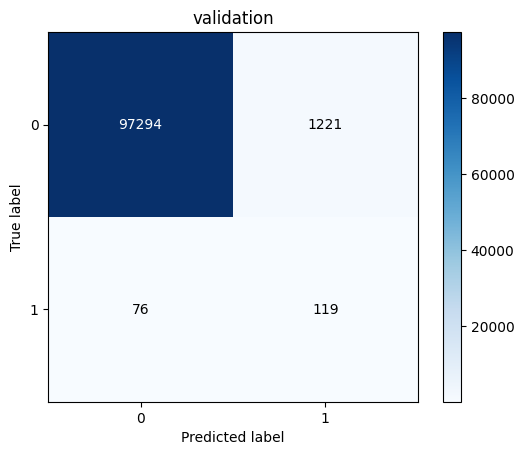

In [26]:
val_metrics = evaluate_model(
    val_true_label, val_pred_label, confusion_title="validation"
)
print(
    f"recall: {val_metrics['recall']}, "
    + f"precision: {val_metrics['precision']}, "
    + f"specificity: {val_metrics['specificity']}"
)

## 4 Report

In [27]:
if type(model) is LogisticRegression:
    model_coefs = (
        pd.DataFrame(zip(selected, model.coef_[0]), columns=["feature", "coef"])
        .sort_values("coef")
        .reset_index(drop=True)
    )
    print(model_coefs)

In [28]:
if type(model) in {RandomForestClassifier, GradientBoostingClassifier}:
    feature_importance = pd.DataFrame(
        zip(selected, model.feature_importances_), columns=["feature", "importance"]
    )
    print(feature_importance)

                                             feature  importance
0    snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio    0.030061
1  snd_rcv_mean_amt_usd_tx_median_log_to_median_r...    0.702305
2              amount_usd_tx_sum_log_to_median_ratio    0.051626
3   snd_rcv_life_time_sec_tx_min_log_to_median_ratio    0.103355
4  snd_rcv_mean_time_diff_sec_tx_sum_log_to_media...    0.018748
5          snd_rcv_tx_cnt_tx_sum_log_to_median_ratio    0.042357
6  snd_rcv_time_diff_sec_tx_mean_log_to_median_ratio    0.051548


In [29]:
train_pred_label = model.predict(model_train_data.loc[:, selected])

In [30]:
train_results = train_data.loc[:, ["file_name", "label"]].copy()
train_results["pred_label"] = train_pred_label
train_results["exp_part"] = "train"

In [31]:
validation_results = validation_data.loc[:, ["file_name", "label"]]
validation_results["pred_label"] = val_pred_label
validation_results["exp_part"] = "validation"

In [32]:
model_result = pd.concat([train_results, validation_results])

In [33]:
cases = pd.read_csv("Validated_V0_Desriptions.csv").rename(
    {"File Names": "file_name", "Exploit Types": "exploit_type"}, axis=1
)
cases["file_name"] += ".csv"
cases = cases.loc[
    :, ["file_name", "exploit_type", "Minimum Time", "train/test splits", "Attack Link"]
]

In [34]:
model_results = cases.merge(model_result)

In [35]:
file_report, exploit_report = report_by_sections(model_results)

In [36]:
exploit_report

,exploit_type,exp_part,files,tp,fp,tn,fn,recall,precision
0,Access Control,train,54,1166,12956,377912,142,0.891437,0.082566
1,Access Control,validation,11,98,978,58482,36,0.731343,0.091078
2,Flash Loan Attack,train,18,18,594,59476,1,0.947368,0.029412
3,Flash Loan Attack,validation,5,16,222,26164,2,0.888889,0.067227
4,Phishing,train,16,2,153,9030,24,0.076923,0.012903
5,Phishing,validation,5,2,10,236,18,0.100000,0.166667
6,Price Manupilation,train,5,5,6,652,0,1.000000,0.454545
7,Price Manupilation,validation,1,0,11,585,1,0.000000,0.000000
8,Rug pull,train,25,169,678,55423,144,0.539936,0.199528
9,Rug pull,validation,6,3,0,11827,19,0.136364,1.000000


In [37]:
file_report.groupby("exp_part")["catch_any"].mean()

exp_part
train         0.644068
validation    0.535714
Name: catch_any, dtype: float64

In [38]:
model_train_data["pred_label"] = train_pred_label
validation_model_data["pred_label"] = val_pred_label

In [39]:
def plot_case(df, file_name, features, max_points=5000):
    if type(features) is str:
        features = [features]
    plot_data = df.loc[
        df["file_name"] == file_name, ["block_time", "label", "pred_label"] + features
    ]
    if plot_data.shape[0] > max_points:
        plot_data = plot_data.sort_values("block_time").tail(max_points)
    fig, axs = plt.subplots(ncols=1, nrows=len(features), figsize=[12, 10])
    fig.suptitle(file_name)
    for i in range(len(features)):
        ax = axs[i]
        feature = features[i]
        ax.set_title(feature)
        is_tn = (plot_data["label"] == 0) & (plot_data["pred_label"] == 0)
        is_tp = (plot_data["label"] == 1) & (plot_data["pred_label"] == 1)
        is_fp = (plot_data["label"] == 0) & (plot_data["pred_label"] == 1)
        is_fn = (plot_data["label"] == 1) & (plot_data["pred_label"] == 0)
        ax.scatter(
            plot_data["block_time"][is_tn],
            plot_data[feature][is_tn],
            color="green",
            label="tn",
        )
        ax.scatter(
            plot_data["block_time"][is_tp],
            plot_data[feature][is_tp],
            color="red",
            label="tp",
        )
        ax.scatter(
            plot_data["block_time"][is_fp],
            plot_data[feature][is_fp],
            color="green",
            edgecolors="red",
            label="fp",
            linewidths=2,
        )
        ax.scatter(
            plot_data["block_time"][is_fn],
            plot_data[feature][is_fn],
            color="red",
            edgecolors="green",
            label="fn",
            linewidths=2,
        )
        ax.legend()
        fig.subplots_adjust(hspace=0.4)

In [40]:
top_features = list(feature_importance.sort_values("importance")["feature"].tail(3))

In [41]:
top_features

['amount_usd_tx_sum_log_to_median_ratio',
 'snd_rcv_life_time_sec_tx_min_log_to_median_ratio',
 'snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio']

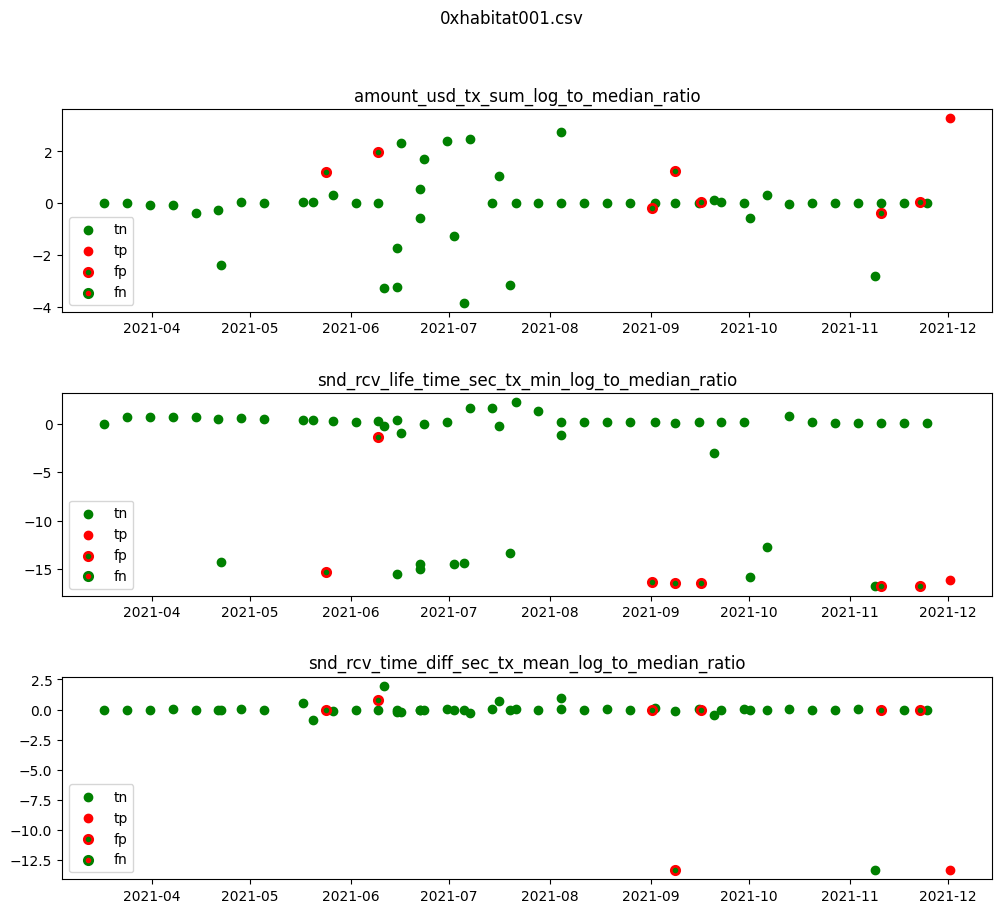

In [42]:
plot_case(
    validation_model_data,
    "0xhabitat001.csv",
    [
        "amount_usd_tx_sum_log_to_median_ratio",
        "snd_rcv_life_time_sec_tx_min_log_to_median_ratio",
        "snd_rcv_time_diff_sec_tx_mean_log_to_median_ratio",
    ],
)